# Normal Distribution

> Each feature distributes like a normal distribution

Here we see that inter-class and intra-class variations withing each PCA component tend to distribute as a Gaussian. We see this both for the different class means, and for random classes - for features of those classes, around the class mean (projected onto the subspace orthogonal to the class mean).

We also see that correlations between components are concentrated around 0, suggesting that components are independent. 

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
from sklearn.decomposition import PCA
from scipy.stats import norm
from fastai.vision.all import *

from similarity_learning.all import *

from Few_Shot_Feature_Space.utils import *

In [ ]:
def per_component_hist(xs, axs):
    pca = PCA()
    pca.fit(xs.cpu())
        
    comp_idxs = [i*pca.n_components_//(len(axs)-1) for i in range(len(axs)-2)] + [pca.n_components_-1]
    for comp_idx, ax in zip(comp_idxs, axs[:-1]):
        dir = Tensor(pca.components_[comp_idx]).cuda()
        projected = (xs @ dir).cpu()
        plot_hist(projected, ax=ax)
        ax.set_title(f'Component #{comp_idx+1} out of {pca.n_components_}')

    n_comps = [i for i, v in enumerate(pca.explained_variance_ratio_.cumsum()) if v<.9999][-1] + 1
    xs = xs @ Tensor(pca.components_[:n_comps]).T.cuda()

    corr = xs.T.corrcoef().cpu()
    corr.fill_diagonal_(0)  # we only care about inter-component correlations
    plot_hist(corr.view(-1), ax=axs[-1])
    axs[-1].set_title('Correlations Between Main Components')
    

def class_mean_per_components(centroids, n_plots):
    n_plots +=1 #  covaraince plot
    fig, axs = plt.subplots(1, n_plots, figsize=(n_plots*5, 5))
    fig.suptitle('Class Mean Distributions Across PCA Components')
    per_component_hist(centroids, axs)

def off_mean_per_classes_and_components(class_ftrs, n_plots):
    n_plots +=1 #  covaraince plot
    fig, axss = plt.subplots(4, n_plots, figsize=(n_plots*5, 20))
    fig.suptitle('Around-Mean Distributions Across Classes and PCA Components')
    cluster_candidates = [f for f in class_ftrs.values() if f.size(0) > 100]
    for ftrs, axs in zip(random.sample(cluster_candidates, len(axss)), axss):
        per_component_hist(ftrs.off_centroid_features, axs)

In [ ]:
def plot(dl, fe, n_plots=5):
    class_ftrs = ClassFeatures.compute(dl, fe)
    centroids = torch.stack([f.centroid for f in class_ftrs.values()])
    global_mean = centroids.mean(0)

    class_mean_per_components(centroids - global_mean, n_plots)

    off_mean_per_classes_and_components(class_ftrs, n_plots)

In [ ]:
vggface2_fe, casia_webface_fe = fr_feature_extractors()
lfw_dl, pfr_dl = fr_dataloaders()

## VGGFace2

### LFW

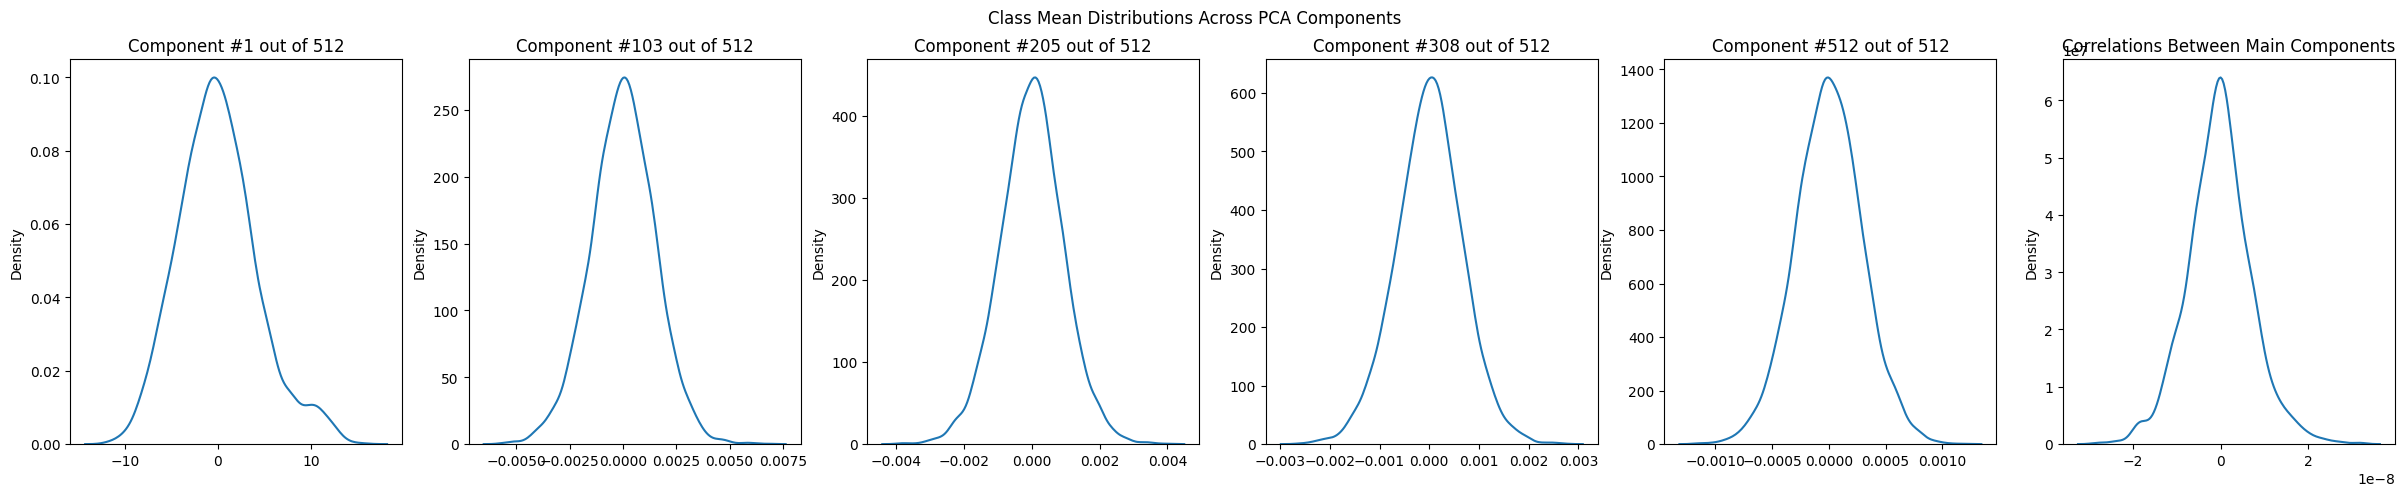

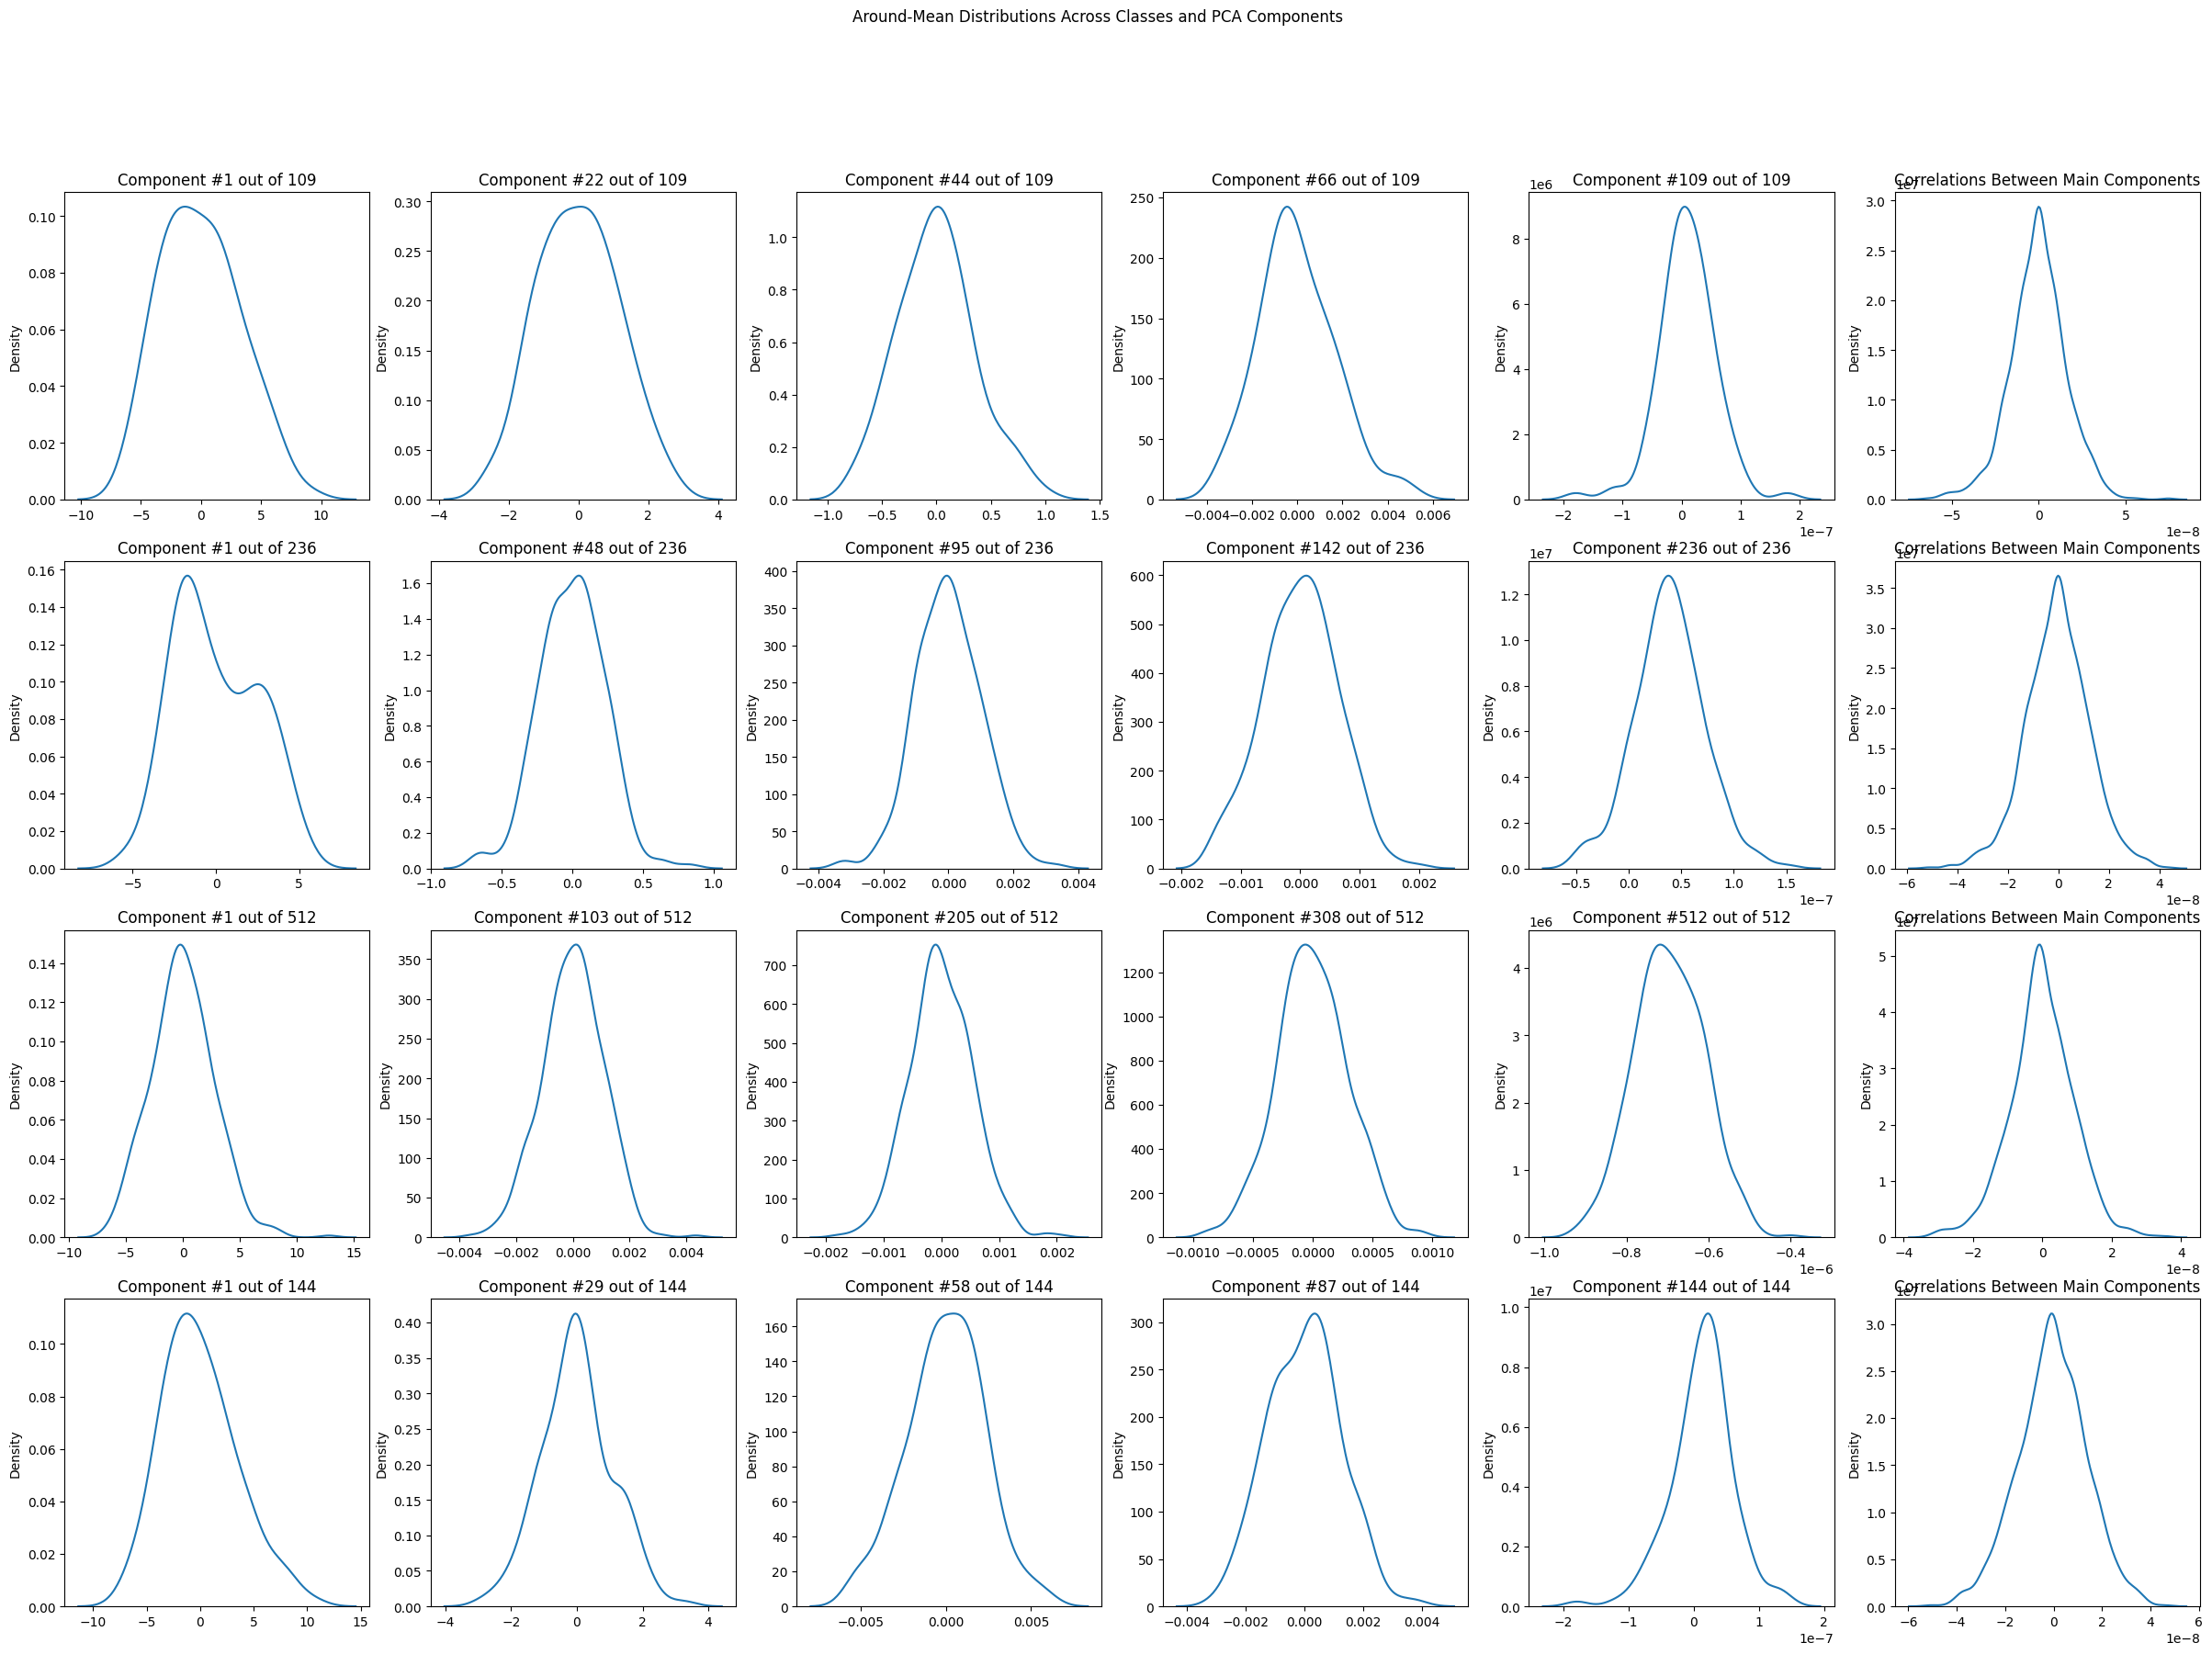

In [ ]:
plot(lfw_dl, vggface2_fe)

### PFR

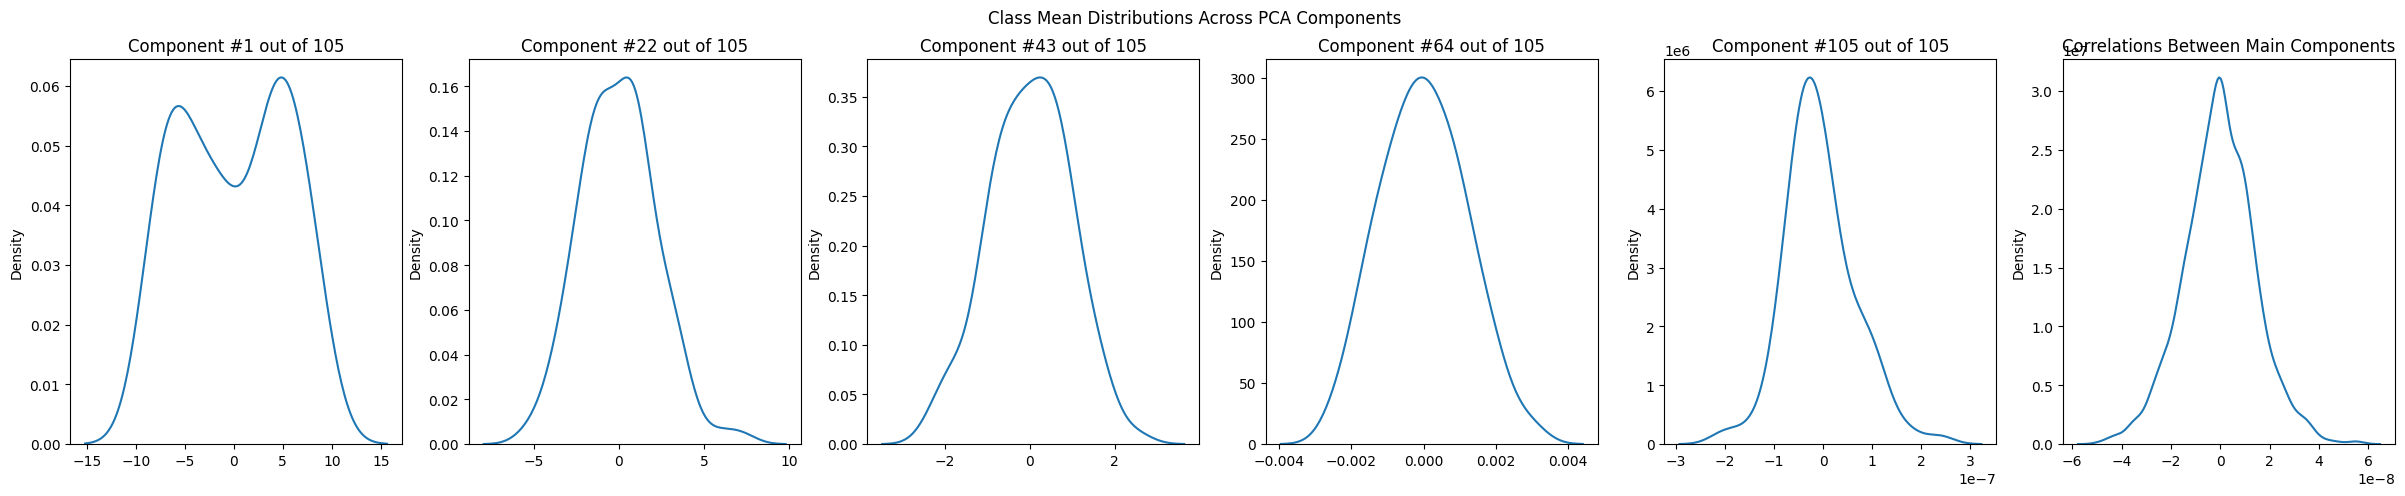

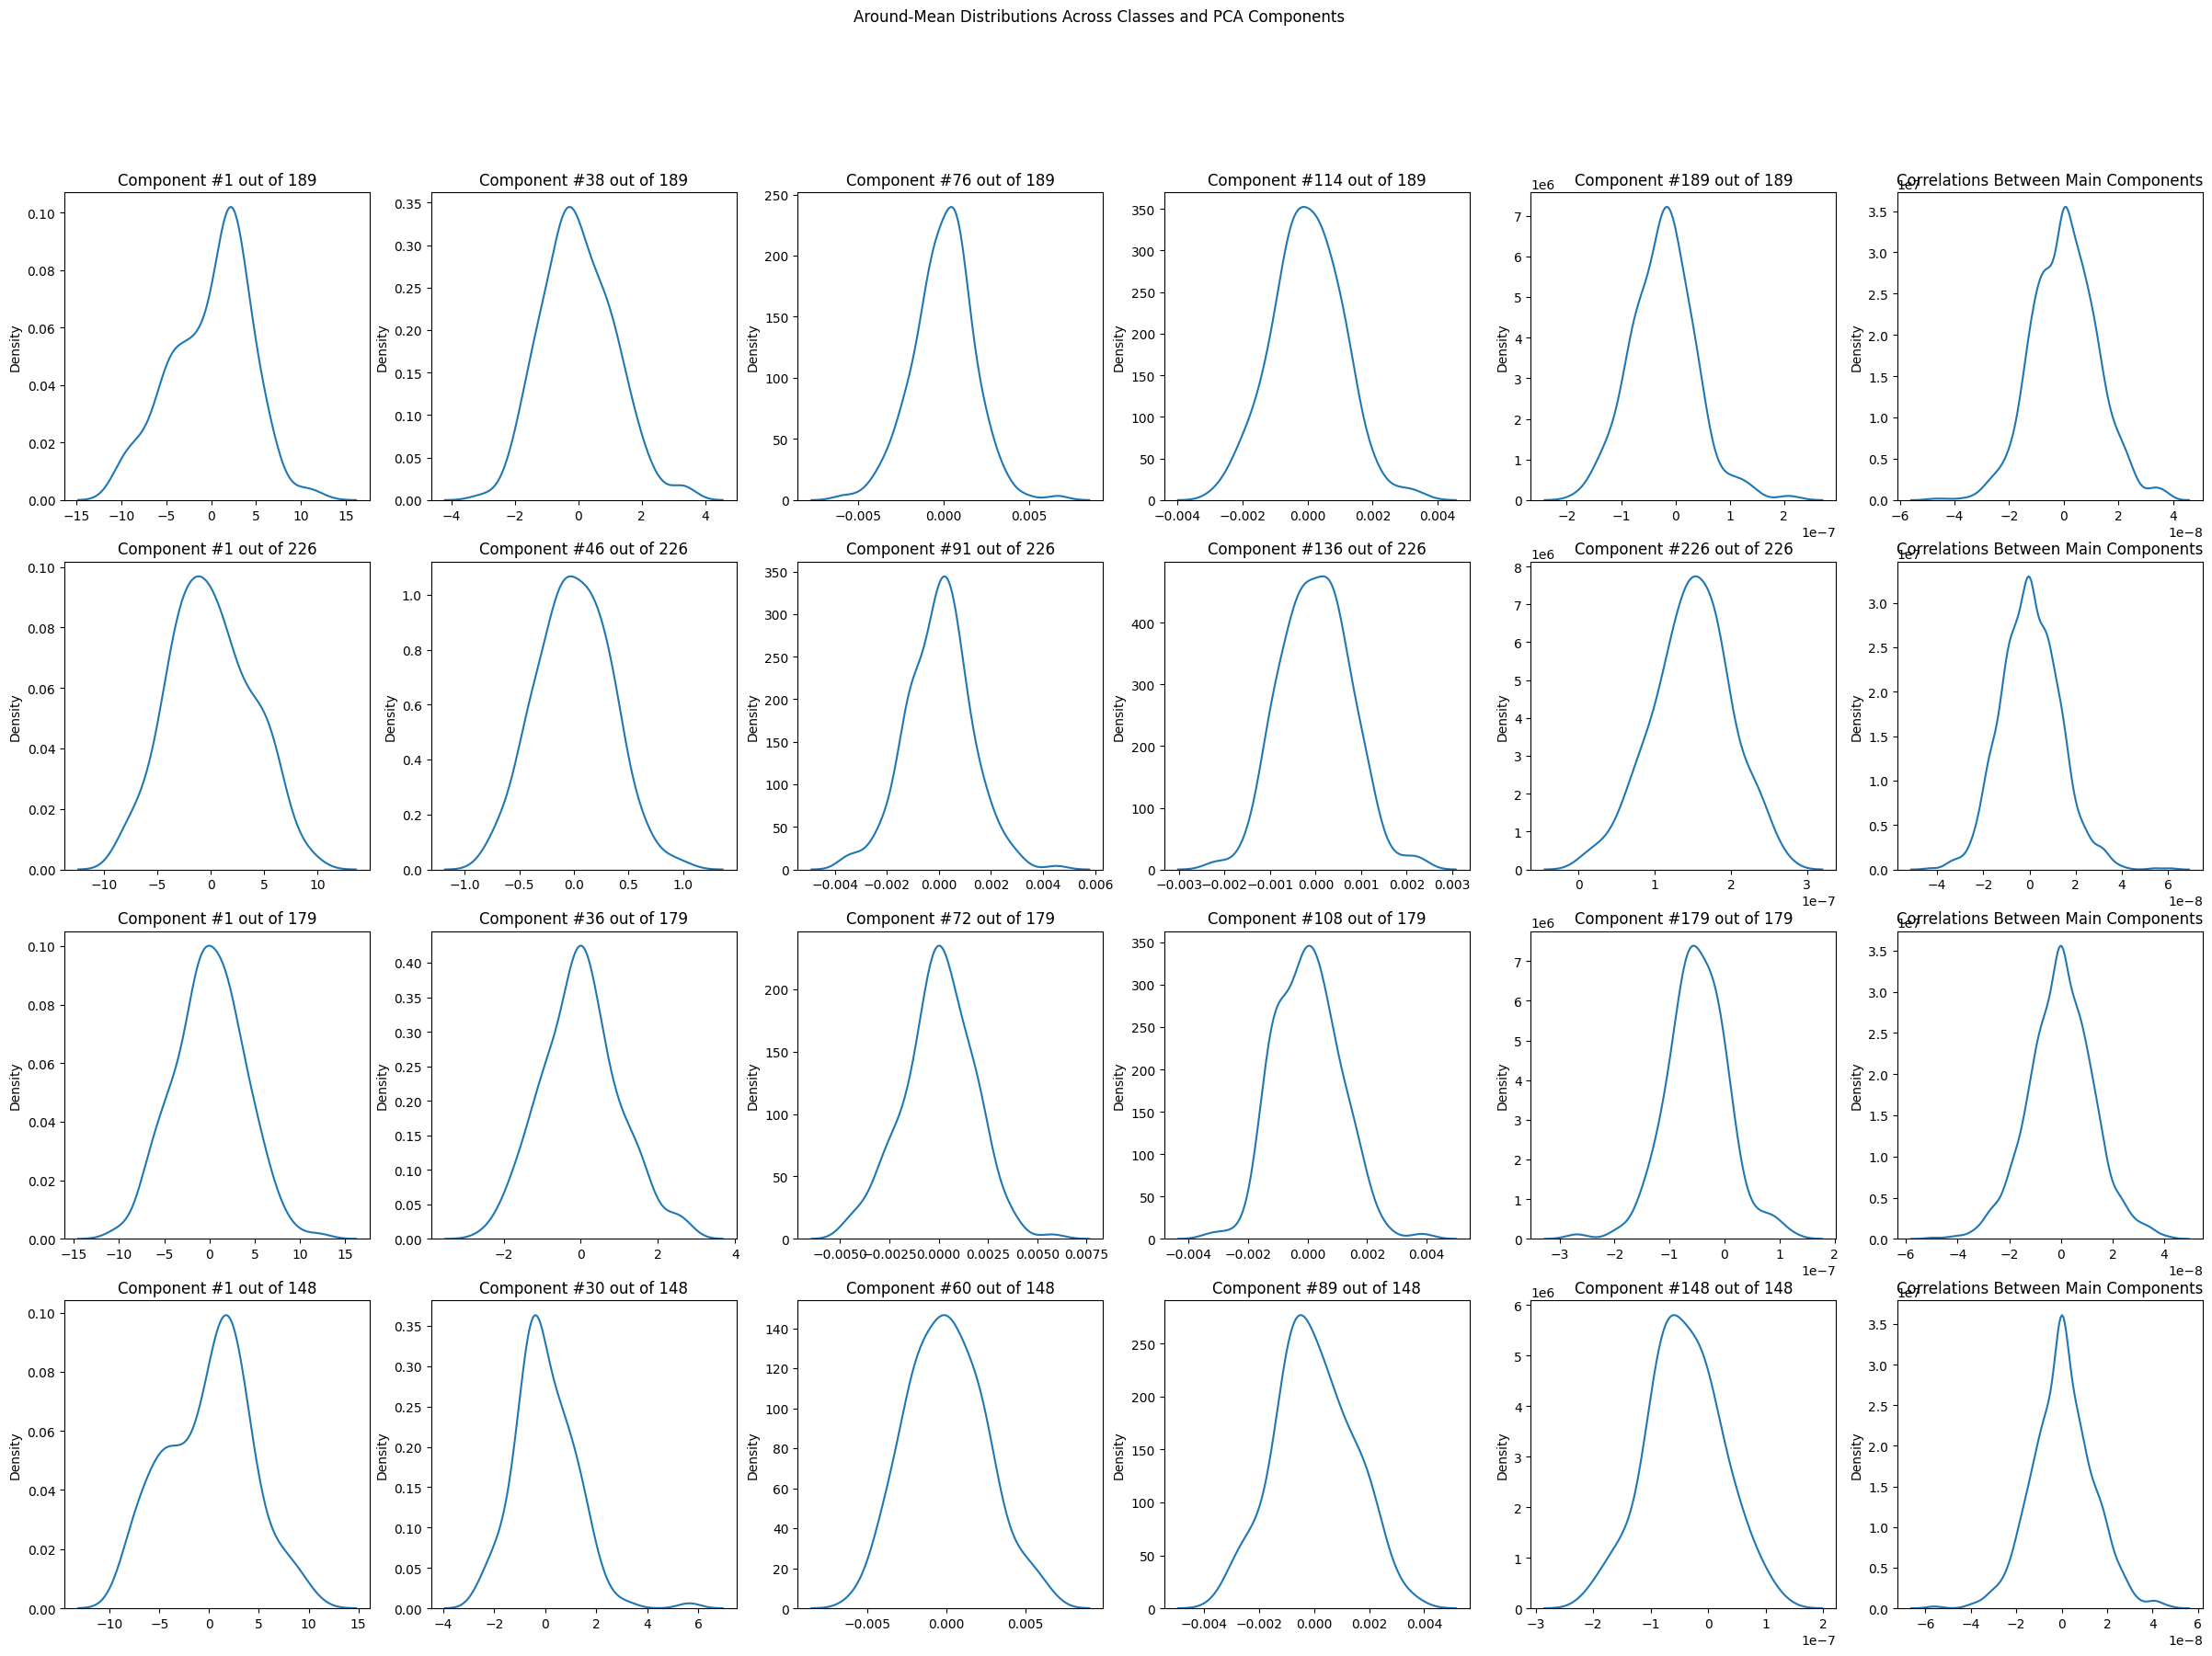

In [ ]:
plot(pfr_dl, vggface2_fe)

## CASIA-WebFace

### LFW

In [ ]:
plot(lfw_dl, casia_webface_fe)

### PFR

In [ ]:
plot(pfr_dl, casia_webface_fe)